<a href="https://colab.research.google.com/github/wkemilylau/MeiboscorePredictor/blob/main/meiboscore_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Meibomian gland detection deep learning model

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.df.iloc[:, 1])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        # Change file extension from .png to .JPG
        img_name = img_name.replace('.png', '.JPG')
        image = Image.open(img_name)
        label = self.df.iloc[idx, 1]
        encoded_label = self.label_encoder.transform([label])[0]
        if self.transform:
            image = self.transform(image)
        return image, encoded_label


# Paths
csv_file = 'labels.csv'  # Change this to your CSV file name
root_dir = '/content/images'  # Change this to your image folder path

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 448)),
    transforms.ToTensor(),
])


In [ ]:
# Create custom dataset
from torch.utils.data import random_split
custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)
train_dataset, test_dataset = random_split(custom_dataset, [0.8,0.2])

len(train_dataset), len(test_dataset)

(800, 199)

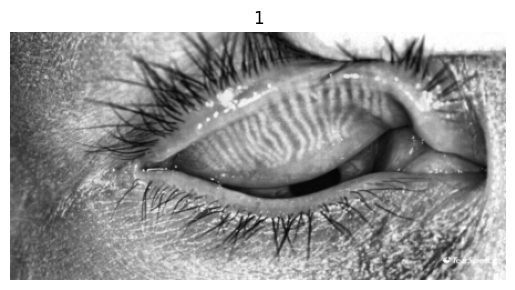

In [ ]:
image, label = images[2], labels[2]

# Convert the PyTorch tensor to a numpy array and transpose it to match the shape expected by matplotlib
image_np = image.permute(1, 2, 0).numpy()

# Convert the label back to its original form using the label encoder
original_label = custom_dataset.label_encoder.inverse_transform([label])[0]

# Display the image
plt.imshow(image_np)
plt.title(original_label)
plt.axis('off')  # Hide axes
plt.show()

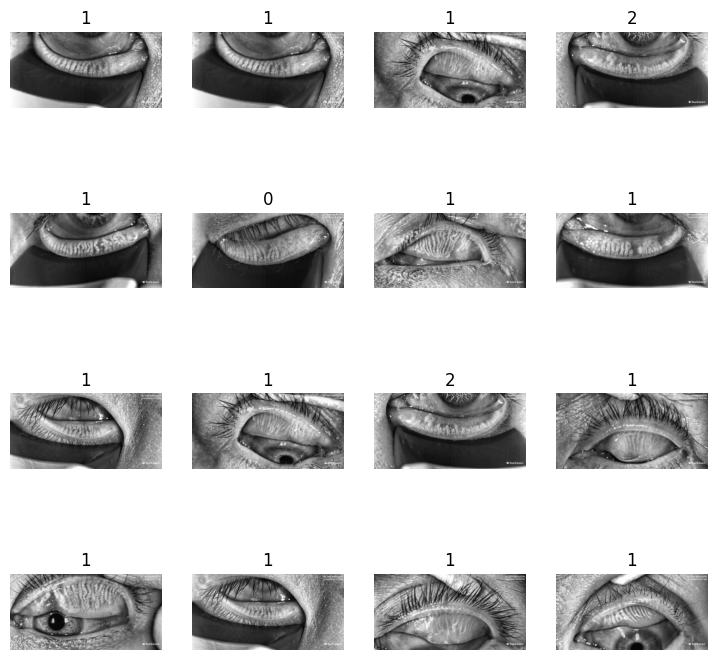

In [ ]:
# Plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
  idx = np.random.randint(0, 32)
  image = train_dataset[idx][0]
  image_np = image.permute(1, 2, 0).numpy()
  label = train_dataset[idx][1]
  original_label = custom_dataset.label_encoder.inverse_transform([label])[0]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image_np)
  plt.title(original_label)
  plt.axis(False)

In [ ]:
# Dataloader
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

len(train_dataloader), len(test_dataloader)

(50, 13)

In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([16, 3, 224, 448]), torch.Size([16]))

## Baseline model

In [ ]:
# Flatten
flatten_model = nn.Flatten()

# Get a single sample
x = train_dataset[0][0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([3, 224, 448]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 100352]) -> [color_channels, height*width]


In [ ]:
class MeibographyModel_0(nn.Module):
  def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2:int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units_1),
        nn.Linear(in_features = hidden_units_1, out_features = hidden_units_2),
        nn.Linear(in_features = hidden_units_2, out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
model_0 = MeibographyModel_0(input_shape=301056,
                             hidden_units_1 = 32,
                             hidden_units_2 = 32,
                             output_shape = 1)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.L1Loss() # this is also called "criterion"/"cost function" in some places
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=1e+17)
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e14, weight_decay=1e5)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[-1.0000e+16,  1.0000e+16,  1.0000e+16,  ..., -1.0000e+16,
                        1.0000e+16,  1.0000e+16],
                      [ 1.0000e+16, -1.0000e+16,  1.0000e+16,  ...,  1.0000e+16,
                        1.0000e+16,  1.0000e+16],
                      [ 1.0000e+16, -1.0000e+16,  1.0000e+16,  ...,  1.0000e+16,
                        1.0000e+16, -1.0000e+16],
                      ...,
                      [ 1.0000e+16,  1.0000e+16,  1.0000e+16,  ...,  1.0000e+16,
                       -1.0000e+16, -1.0000e+16],
                      [-1.0000e+16,  1.0000e+16, -1.0000e+16,  ...,  1.0000e+16,
                        1.0000e+16, -1.0000e+16],
                      [-1.0000e+16,  1.0000e+16, -1.0000e+16,  ...,  1.0000e+16,
                       -1.0000e+16, -1.0000e+16]])),
             ('layer_stack.1.bias',
              tensor([ 1.0000e+16, -1.0000e+16, -1.0000e+16, -1.0000e+16, -1.0000e+16,
                      -

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm


# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y.view(-1,1))
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 8 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y.view(-1,1)) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss} | Test loss: {test_loss}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/800 samples
Looked at 128/800 samples
Looked at 256/800 samples
Looked at 384/800 samples
Looked at 512/800 samples
Looked at 640/800 samples
Looked at 768/800 samples

Train loss: nan | Test loss: nan, Test acc: 19.51%

Epoch: 1
-------
Looked at 0/800 samples
Looked at 128/800 samples
Looked at 256/800 samples
Looked at 384/800 samples
Looked at 512/800 samples
Looked at 640/800 samples
Looked at 768/800 samples

Train loss: nan | Test loss: nan, Test acc: 19.51%

Epoch: 2
-------
Looked at 0/800 samples
Looked at 128/800 samples
Looked at 256/800 samples
Looked at 384/800 samples
Looked at 512/800 samples
Looked at 640/800 samples
Looked at 768/800 samples

Train loss: nan | Test loss: nan, Test acc: 19.51%

